# Create/convert an input dataset in MRD format

Prepare a dataset in the [MRD file format](https://ismrmrd.readthedocs.io/en/latest/mrd_files.html) by converting acquired data or by generating a synthetic phantom dataset.  Raw k-space data can be converted using tools such as [siemens_to_ismrmrd](https://github.com/ismrmrd/siemens_to_ismrmrd), [ge_to_ismrmrd](https://github.com/ismrmrd/ge_to_ismrmrd), [philips_to_ismrmrd](https://github.com/ismrmrd/philips_to_ismrmrd), and [bruker_to_ismrmrd](https://github.com/ismrmrd/bruker_to_ismrmrd), while DICOM image data can be converted to DICOM using [dicom2mrd.py](https://github.com/kspaceKelvin/python-ismrmrd-server#UsingDICOMimagesasinputdata).  The [generate_cartesian_shepp_logan_dataset.py](../generate_cartesian_shepp_logan_dataset.py) script can also be used to generate multi-channel raw k-space data.


## Option 1: Simulate a raw k-space dataset of the Shepp-Logan phantom
**Note** This section requires that the [ismrmrd-python-tools](https://github.com/ismrmrd/ismrmrd-python-tools) repo be installed (see [readme.md](../readme.md#Settingupacondaenvironment))

In [ ]:
# Generate a raw k-space dataset of the Shepp-Logan phantom
# Add root of this repo to the path, as this notebook is in a subdirectory
import sys
sys.path.append('../')

import os
import generate_cartesian_shepp_logan_dataset

inputFilename = 'raw.mrd'

if os.path.exists(inputFilename):
    raise Exception('File %s already exists!' % inputFilename)
    # Don't overwrite automatically, but uncomment below to delete the file
    # os.remove(inputFilename)

generate_cartesian_shepp_logan_dataset.create(filename=inputFilename, matrix_size=256, coils=8, oversampling=2, repetitions=1, acceleration=1, noise_level=0.05)

Creating Shepp-Logan phantom raw data:
Matrix 256x256 at R=1 with 1 repetitions
8 coils with 2 oversampling and 0.05 noise level
Saved to raw.mrd


## Option 2: Convert raw k-space data acquired from an MRI scanner

In [7]:
# Run siemens_to_ismrmrd to convert a .dat file into MRD format
# Note that as there is no Windows executable, this must be run in Linux or in a devcontainer

# Relative path to Siemens .dat file (note this .ipynb file likely exists in the doc subfolder!)
datFile = '../data/MiniFLASH_Fire.dat'

# Measurement in the multi-RAID .dat file to convert.  Note the .dat file may contain dependent
# scans, e.g. AdjCoilSens and the desired scan is usually the last in the multi-RAID file
# Negative indices are relative to the end (e.g. -1 for the last measurement)
measNum = '-1'

# Parameter map and stylesheet to use to convert from Siemens parameter buffers to an MRD header.
# These can specify a relative path to local files or files embedded inside siemens_to_ismrmrd.
# These arguments can also be omitted and will default to these values.
paramMap      = None
paramMapStyle = None

# The output file can be specified with the "--output" option, but will be named with the same
# filename as the input file (with a .mrd extension) if omitted.

import subprocess
import os

inputFilename = os.path.splitext(datFile)[0] + '.mrd'
if os.path.exists(inputFilename):
    raise Exception('File %s already exists!' % inputFilename)
    # Don't overwrite automatically, but use the below to delete the file
    # os.remove(inputFilename)

command = ['siemens_to_ismrmrd', '--measNum', measNum, '--file', datFile]
if paramMap is not None:
    command.extend(('--pMap', paramMap))

if paramMapStyle is not None:
    command.extend(('--pMapStyle', paramMapStyle))

try:
    result = subprocess.run(command, check=True, text=True, capture_output=True)
    print("Output:", result.stdout)
except subprocess.CalledProcessError as e:
    raise Exception("Error:", e.stderr)

Output: Siemens file is: ../data/MiniFLASH_Fire.dat
Output file not specified -- using ../data/MiniFLASH_Fire.mrd
-----------------------------------------------------------------
Converting measurement 1 into file ../data/MiniFLASH_Fire.mrd in group dataset
-----------------------------------------------------------------
Using parameter map: IsmrmrdParameterMap_Siemens.xml
This file contains 1 measurement(s).
VD line file detected.
Protocol name [1]: MiniFLASH_Fire
Number of parameter buffers: 6
Buffer Name: Config
Buffer Name: Dicom
Buffer Name: Meas
Buffer Name: MeasYaps
Buffer Name: Phoenix
Buffer Name: Spice
Trajectory is: 1
Failed to find YAPS.lFirstFourierLine array
Failed to find YAPS.lFirstFourierPartition array
center_line = 64
center_partition = 0
Baseline: N4_VE11C_LATEST_20160120
Software version: syngo MR E11
Protocol name: MiniFLASH_Fire
Dwell time: 15000
Using parameter XSL: IsmrmrdParameterMap_Siemens.xsl
Study time: 16:06:09
Last scan reached...



## Visualize raw k-space data
Inspect and visualize the raw k-space dataset using the [ismrmrd-python](https://github.com/ismrmrd/ismrmrd-python) library.  Data from multiple scans/acquisitions can be stored in a single file, grouped in ['datasets'](https://ismrmrd.readthedocs.io/en/latest/mrd_files.html#mrd-file-format).  The datasets in a file can be listed with:

File "../data/MiniFLASH_Fire.mrd" contains 1 datasets:
  dataset
Reading dataset "dataset" from file "../data/MiniFLASH_Fire.mrd"
There are 128 imaging readouts out of a total of 128 readouts
Loop index counters with unique values:
  kspace_encode_step_1 has 128 unique values (min:   0, max: 127)
Readouts with AcquisitionHeader flags present:
[  0] Lin 0: ACQ_FIRST_IN_SLICE
[127] Lin 127: ACQ_LAST_IN_MEASUREMENT, ACQ_LAST_IN_REPETITION, ACQ_LAST_IN_SLICE


/root/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


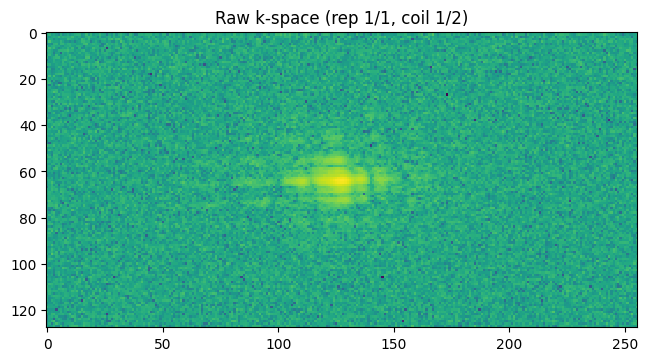

In [3]:
# Display the generated raw k-space data
import h5py
import ismrmrd
import numpy as np
import matplotlib.pyplot as plt

datasetName = 'dataset'

# List all datasets in the file
with h5py.File(inputFilename, 'r') as d:
    dsetNames = d.keys()
    print('File "%s" contains %d datasets:' % (inputFilename, len(dsetNames)))
    print(' ', '\n  '.join(dsetNames))
    group = list(dsetNames)[0]

    datasetName = list(d.keys())[0]

print('Reading dataset "%s" from file "%s"' % (datasetName, inputFilename))
with ismrmrd.Dataset(inputFilename, datasetName, False) as dset:
    # Read MRD header
    xmlHeader = dset.read_xml_header().decode('utf-8')
    mrdHeader = ismrmrd.xsd.CreateFromDocument(xmlHeader)

    # Get all readouts
    acqs = [dset.read_acquisition(idx) for idx in range(dset.number_of_acquisitions())]

    # Limit to imaging (non-noise) readouts
    imgAcqs = [acq for acq in acqs if not acq.is_flag_set(ismrmrd.ACQ_IS_NOISE_MEASUREMENT)]

    print('There are %d imaging readouts out of a total of %d readouts' % (len(imgAcqs), dset.number_of_acquisitions()))

# List index counters that have >1 unique values
idxFields = ['average', 'contrast', 'kspace_encode_step_1', 'kspace_encode_step_2', 'phase', 'repetition', 'segment', 'set', 'slice']
print("Loop index counters with unique values:")
for field in idxFields:
    vals = set([getattr(acq.idx, field) for acq in imgAcqs])
    if len(vals) > 1:
        print(f'  {field:20s} has {len(vals):3d} unique values (min: {min(vals):3d}, max: {max(vals):3d})')

for i in range(8):
    vals = set([acq.idx.user[i] for acq in imgAcqs])
    if len(vals) > 1:
        print(f'  user[{i}]              has {len(vals):3d} unique values (min: {min(vals):3d}, max: {max(vals):3d})')

# Format data into single [cha PE RO rep] array
lin = [acq.idx.kspace_encode_step_1 for acq in imgAcqs]
rep = [acq.idx.repetition           for acq in imgAcqs]

raw = np.zeros((mrdHeader.acquisitionSystemInformation.receiverChannels, 
                mrdHeader.encoding[0].encodedSpace.matrixSize.y, 
                mrdHeader.encoding[0].encodedSpace.matrixSize.x, 
                mrdHeader.encoding[0].encodingLimits.repetition.maximum+1), 
                imgAcqs[0].data.dtype)

for acq, lin, rep in zip(imgAcqs, lin, rep):
    raw[:,lin,-acq.data.shape[1]:,rep] = acq.data

# Show the AcquisitionHeader flags for each line of k-space
print("Readouts with AcquisitionHeader flags present:")
acqFlags = [field for field in dir(ismrmrd) if field.startswith('ACQ_')]
for i, acq in enumerate(imgAcqs):
    strFlags = ", ".join([field for field in acqFlags if acq.is_flag_set(getattr(ismrmrd, field))])
    if strFlags:
        print(f'[{i:3d}] Lin {acq.idx.kspace_encode_step_1}: {strFlags}')

t = np.log(np.abs(raw[0,:,:,0]))
t[np.isinf(t)] = 0

dpi = 100
plt.figure(figsize=(3*t.shape[1] / dpi, 3*t.shape[0] / dpi), dpi=dpi)
plt.imshow(t, interpolation='nearest')
plt.title('Raw k-space (rep %d/%d, coil %d/%d)' % (1, mrdHeader.encoding[0].encodingLimits.repetition.maximum+1, 1, mrdHeader.acquisitionSystemInformation.receiverChannels))
# plt.axis('off')
plt.show()


## Option 3: Convert a set of DICOMs
For image processing workflows, it may also be useful to use DICOM images as input data.  These can be converted to MRD format using the [dicom2mrd.py](../dicom2mrd.py) script.  Not that the header information from data converted in this way may differ from data converted from the scanner.

In [1]:
# Folder containing DICOM files
dicomFolder = '../data/dicom'
inputFilename = 'dicoms.mrd'

# Add root of this repo to the path, as this notebook is in a subdirectory
import sys
sys.path.append('../')

import dicom2mrd
from types import SimpleNamespace

# Add root of this repo to the path, as this notebook is in a subdirectory
import sys
sys.path.append('../')

# Adjust the logging configuration otherwise INFO level isn't shown in notebook output
import logging
logging.getLogger().setLevel(logging.INFO)

# Specify client arguments for recon
args = SimpleNamespace(**dicom2mrd.defaults)
args.folder   = dicomFolder
args.outFile  = inputFilename

dicom2mrd.main(args)

Found 1 unique series from 3 files in folder ../data/dicom
Creating MRD XML header from file ../data/dicom/T1MES.MR.SIEMENS_R_D_USERS_KELVIN.0001.0007.2017.08.17.14.12.24.446056.26633053.IMA
<?xml version="1.0" encoding="ascii"?>
<ismrmrdHeader xmlns="http://www.ismrm.org/ISMRMRD">
 <measurementInformation>
  <measurementID>1.3.12.2.1107.5.2.18.41503.2017081713310056790666960.0.0.0</measurementID>
  <patientPosition>HFS</patientPosition>
  <protocolName>3 plane loc</protocolName>
  <frameOfReferenceUID>1.3.12.2.1107.5.2.18.41503.2.20170817133030435.0.0.0</frameOfReferenceUID>
 </measurementInformation>
 <acquisitionSystemInformation>
  <systemVendor>SIEMENS</systemVendor>
  <systemModel>Aera</systemModel>
  <systemFieldStrength_T>1.5</systemFieldStrength_T>
  <institutionName>Northwestern Memorial Hospital</institutionName>
  <stationName>AWP41503</stationName>
 </acquisitionSystemInformation>
 <experimentalConditions>
  <H1resonanceFrequency_Hz>63870000</H1resonanceFrequency_Hz>
 </ex

## Option 4: Save data using server.py
For inline integration with an MRI scanner or another data source, the conversion to MRD may be done with vendor-provided software.  In this case, it may be desirable to use MRD server in this repository to save a copy of data that it receives, particularly for development purposes.  The data can then be re-run with [client.py](../client.py).  This can be achieved by starting the server with [main.py](../main.py) with the `-s` (`--savedata`) option and data is stored in `/tmp/share/saved_data` unless overridden by the `-S` (`--savedataFolder`) option.


In [ ]:
inputFilename = 'dicoms.mrd'

# Run reconstruction
Algorithms/reconstructions are run as modules by the server component, which implements the [MRD streaming protocol](https://ismrmrd.readthedocs.io/en/latest/mrd_streaming_protocol.html).  The server must be started separately and a client sends data to the server for processing.  The server can be started via command line by running `python main.py`.

If using Visual Studio Code, [launch.json](../.vscode/launch.json) includes a debug configuration to run the server and allow for interactive debugging.  Click on the "Run and Debug" tab on the top left, then click the green play button to start the desired config ("Start server"):

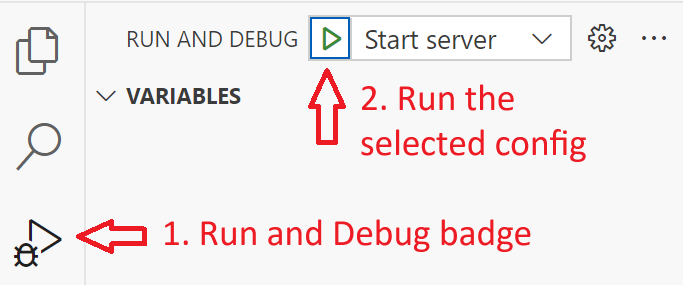

Breakpoints can be set by clicking to the left of the line number in a Python file:

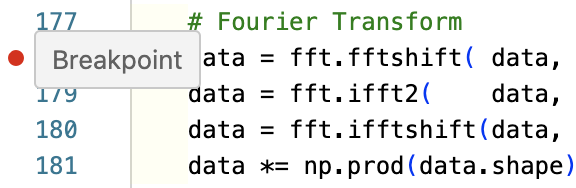

After the server is started, begin the reconstruction by running [client.py](../client.py) on the input dataset.  The recon code/module is selected by using the `config` argument.  The output is stored in a separate MRD file under a dataset named with the current date/time.

In [8]:
# Import the MRD client to send data to server for reconstruction
# Add root of this repo to the path, as this notebook is in a subdirectory
import sys
sys.path.append('../')

import client
from types import SimpleNamespace

# Adjust the logging configuration, otherwise INFO level isn't shown in notebook output by default
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import datetime

outputFilename = 'recon.mrd'

# Specify client arguments for recon
args = SimpleNamespace(**client.defaults)
args.config    = 'invertcontrast'  # Recon module to be used
args.port      = 9020
args.out_group = str(datetime.datetime.now())  # Set when using in notebook, otherwise out_group is time of first import of client module
args.outfile   = outputFilename
args.filename  = inputFilename

client.main(args)

2025-04-09 05:10:11,771 - File ../data/MiniFLASH_Fire.mrd contains 1 groups:
2025-04-09 05:10:11,772 - Reading data from group 'dataset' in file '../data/MiniFLASH_Fire.mrd'
2025-04-09 05:10:11,774 - Connecting to MRD server at localhost:9020


  dataset


/usr/local/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=30714) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
2025-04-09 05:10:11,779 - Sending remote config file name 'invertcontrast'
2025-04-09 05:10:11,780 - --> Sending MRD_MESSAGE_CONFIG_FILE (1)
2025-04-09 05:10:11,787 - --> Sending MRD_MESSAGE_METADATA_XML_TEXT (3)
2025-04-09 05:10:11,788 - Starting raw data session
2025-04-09 05:10:11,790 - Found 128 raw data readouts
2025-04-09 05:10:11,795 - --> Sending MRD_MESSAGE_ISMRMRD_ACQUISITION (1008) (total: 1)
2025-04-09 05:10:11,999 - --> Sending MRD_MESSAGE_ISMRMRD_ACQUISITION (1008) (total: 100)
2025-04-09 05:10:12,055 - --> Sending MRD_MESSAGE_CLOSE (4)
2025-04-09 05:10:12,068 - <-- Received MRD_MESSAGE_TEXT (5)
2025-04-09 05:10:12,070 -     INFO     Total processing time: 14.19 ms
2025-04-09 05:10:12,071 - <-- Received MRD_MESSAGE_ISMRMRD_IMAGE (1022)
2025-04-09 05:10:12,072 -     Image is size

# Display the reconstructed/processed images
The output is an [HDF5-formatted file](https://www.hdfgroup.org/downloads/hdfview/) that is organized in the [MRD file format](https://ismrmrd.readthedocs.io/en/latest/mrd_files.html).  It can be opened using MRD toolboxes for [python](https://github.com/ismrmrd/ismrmrd-python) or [MATLAB](https://github.com/ismrmrd/ismrmrd/tree/master/matlab/%2Bismrmrd) or the [ismrmrdviewer](https://github.com/ismrmrd/ismrmrdviewer).  The client can be run multiple times with the same output file and results are grouped by dataset.

File recon.mrd contains 2 groups (reconstruction runs):
  2025-04-09 05:09:41.422618
  2025-04-09 05:10:11.768315
Group 2025-04-09 05:10:11.768315 contains 1 image series:
  image_0 (1 image)
MetaAttributes:
  DataRole                      : Image
  ImageProcessingHistory        : ['PYTHON', 'INVERT']
  Keep_image_geometry           : 1
  WindowCenter                  : 2048.0
  WindowWidth                   : 4096
  SequenceDescriptionAdditional : FIRE
  ImageRowDir                   : ['-0.999999940395355225', '0.000000059604644775', '0.000000000000000000']
  ImageColumnDir                : ['0.000000059604644775', '0.999999940395355225', '0.000000000000000000']


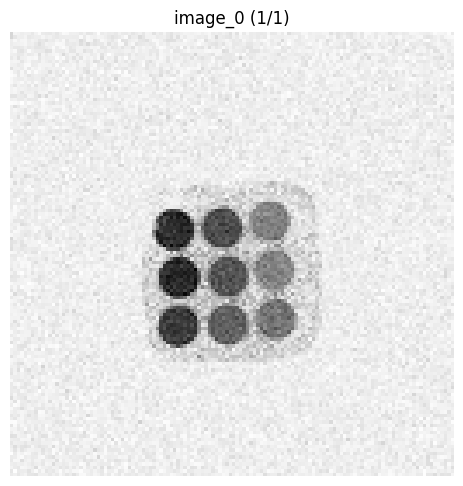

In [ ]:
# Display the reconstructed images
# Add root of this repo to the path, as this notebook is in a subdirectory
import sys
sys.path.append('../')

import h5py
import ismrmrd
import mrdhelper
import numpy as np
import matplotlib.pyplot as plt

# Uncomment to display images from a different output file
# outputFilename = 'recon.mrd'

# If run multiple times, the recon.mrd file will have multiple reconstructed images
# Find the most recent recon run
with h5py.File(outputFilename, 'r') as d:
    dsetNames = d.keys()
    print('File %s contains %d groups (reconstruction runs):' % (outputFilename, len(dsetNames)))
    print(' ', '\n  '.join(dsetNames))
    group = list(dsetNames)[-1]

with ismrmrd.Dataset(outputFilename, group, False) as dset:
    subgroups = dset.list()

    # Images are organized by series number in subgroups that start with 'image_' or 'images_'
    imgGroups = [group for group in list(subgroups) if (group.find('image_') != -1) or (group.find('images_') != -1)]
    imgGroupsWithNumImages = [f'{group} ({dset.number_of_images(group)} image{"s"[:dset.number_of_images(group)^1]})' for group in imgGroups]
    print('Group %s contains %d image series:' % (group, len(imgGroups)))
    print(' ', '\n  '.join(imgGroupsWithNumImages))

    # Show images
    fig, axs = plt.subplots(nrows=len(imgGroups), ncols=1, squeeze=False)

    for i, series in enumerate(imgGroups):
        n = dset.number_of_images(series)
        img = dset.read_image(series, 0)
        axs[i][0].imshow(np.squeeze(img.data), cmap='gray')
        axs[i][0].set_title(series + ' (1/' + str(n) + ')')
        axs[i][0].axis('off')
        axs[i][0].set_aspect('equal')

        # Read and plot ROIs
        meta = ismrmrd.Meta.deserialize(img.attribute_string)
        for key in meta.keys():
            if not key.startswith('ROI_'):
                continue

            roi = meta[key]
            x, y, rgb, thickness, style, visibility = mrdhelper.parse_roi(roi)

            if visibility == 0:
                continue

            lstyle = '-' if (style == 0) else '--'
            axs[i][0].plot(x, y, color=rgb, linewidth=thickness, linestyle=lstyle)
        
        maxKeyLen = max([len(key) for key in meta.keys()])
        print("MetaAttributes:")
        for key, value in meta.items():
            print(f'  {key:{maxKeyLen}} : {value}')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout(pad=0.5)

    plt.show()